In [1]:
import contractions

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-hatespeech/TwitterHate.csv
/kaggle/input/domain-generation-algorithm/words.txt
/kaggle/input/domain-generation-algorithm/dga_project_dga_domain_list_clean.txt
/kaggle/input/domain-generation-algorithm/dga_project_top-1m.csv
/kaggle/input/domain-generation-algorithm/top-1m.csv


In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
#read data
data = pd.read_csv("../input/twitter-hatespeech/TwitterHate.csv")
data.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [4]:
data[data.label==1].sample(5)

,id,label,tweet
9416,9417,1,â¡ï¸ âcharles paladino's racist comments spark calls for resignationâ
11443,11444,1,@user #netanyahuspeech stirs anti-jewish hate &amp; on twitter from progressives
19457,19458,1,#cnn calls #michigan middle school 'build the wall' chant '' #tcot
31594,31595,1,@user you might be a libtard if... #libtard #sjw #liberal #politics
22249,22250,1,"apparently taragon is not a ""christmassy herb"""


In [5]:
data.drop(columns=['id'], inplace = True)
data.rename(columns={'label':'Sentiment'},inplace=True)
data.head()

,Sentiment,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


### Exploratory Data Analysis
1. Number of positive, negative tweets
2. Pie chart for positive and negative tweet percentage
3. Average length of positive negative tweets
4. distribution of length of tweets for positive and negative
5. Word cloud for positive, negative tweets

### Cleaning
1. Normalize casings
2. Remove urls
3. Remove punctuations
4. Remove non-alphabetic characters except emojis
5. Remove hashtags but keep text
6. Remove handles with usernames
7. Remove stopwords

### Slang words handling
1. Create a dictionary of words with frequency
2. Lookup words in a english dictionary and mark present or not present
3. For non-present words, look up their frequencies
4. If less frequent remove

### Train-Val-Test Split
1. Divide the data into train-val-test
2. find less frequent non english tokens from training set
3. remove less frequent non english tokens from validation and test set
4. save all 3 files

## Exploratory Data Analysis

In [6]:
pos_neg = pd.DataFrame(data['Sentiment'].value_counts())
pos_neg.rename(index={0:'Positive', 1:'Negative'}, inplace=True)
pos_neg

,Sentiment
Positive,29720
Negative,2242


[Text(0.5, 0, 'Sentiment'), Text(0, 0.5, 'Count')]

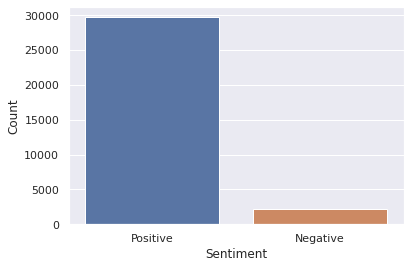

In [7]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(6,4)})
ax = sns.barplot(x = pos_neg.index, y = pos_neg.Sentiment)
ax.set(xlabel = "Sentiment", ylabel = "Count")

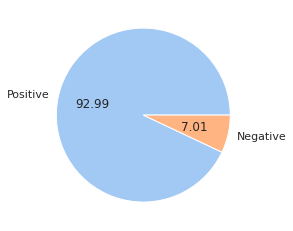

In [8]:
colors = sns.color_palette('pastel')[0:2]
plt.pie(x=pos_neg.Sentiment, labels=pos_neg.index,colors=colors, autopct='%.2f')
plt.show()

In [9]:
data['length'] = data['tweet'].apply(lambda x: len(x))

In [10]:
data.groupby('Sentiment').mean()['length']

Sentiment
0    84.328634
1    90.187779
Name: length, dtype: float64

<AxesSubplot:xlabel='length', ylabel='Count'>

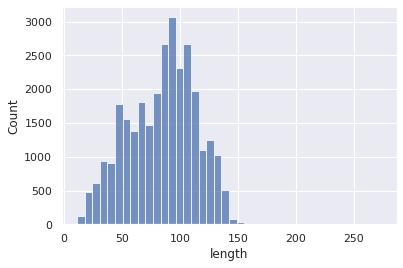

In [11]:
sns.histplot(data=data, x=data.length[data.Sentiment==0], bins=40)

<AxesSubplot:xlabel='length', ylabel='Count'>

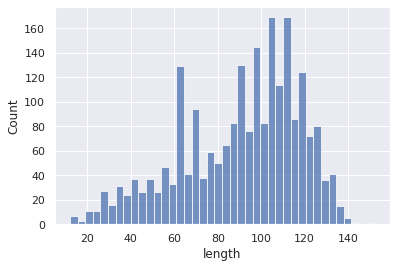

In [12]:
sns.histplot(data=data, x=data.length[data.Sentiment==1], bins=40)

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import TweetTokenizer

### Text cleaning strategy

Lowercase

Remove links

Remove certain punctuations: .?!,[]{}_"

Remove special chars : #$%^&*|\/<>@¦

remove numbers = r'[0-9]+

tweettokenize

    emoji chars:;-() - remove individual instances, not through regex
    
    single characters = r'/b[a-z0-9]/b OR if token is one of these : - ) ( ;

Expand contractions

Remove stopwords

Lemmatization

Remove less frequent non-english tokens


In [14]:
#normalize casings
data['tweet'] = data['tweet'].apply(lambda x: x.lower())

In [15]:
def cleanTweetsRegex(x):
    #remove urls
    pattern_link = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
    x = re.sub(pattern_link, '', x)
    
    pattern_punct = r'[.\?!,\[\]{}_"]'
    x = re.sub(pattern_punct, '', x)
    
    pattern_special = r'[#$%^&\*|\\/<>¦]'
    x = re.sub(pattern_special, '', x)
    
    pattern_nums = r'[0-9]+'
    x = re.sub(pattern_nums, '', x)
    
    return x

In [16]:
data['cleaned_tweets'] = data['tweet'].apply(lambda x: cleanTweetsRegex(x))

In [17]:
data[['cleaned_tweets']].head(5)

,cleaned_tweets
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run
1,@user @user thanks for lyft credit i can't use cause they don't offer wheelchair vans in pdx disapointed getthanked
2,bihday your majesty
3,model i love u take with u all the time in urð± ðððð ððð
4,factsguide: society now motivation


In [18]:
tweetTokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

def tokenizeTweets(tweet, tokenizer=tweetTokenizer):
    single_char_emoji = [':',';','(',')','-']
    return ' '.join([word for word in tokenizer.tokenize(tweet) if word not in single_char_emoji])
    

In [19]:
lem = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemmatize_token(word):
    lst = []
    lst.append(word)
    wordtpl = pos_tag(lst)
    tag = nltk_tag_to_wordnet_tag(wordtpl[0][1])
    if(tag!=None):
        return lem.lemmatize(word,tag)
    else:
        return word

In [20]:
stop = set(stopwords.words('english'))
def normalize_text(x):
    x = tokenizeTweets(x)
    x = contractions.expand_contractions(x)
    return ' '.join([lemmatize_token(word) for word in x.split() if word not in stop])

In [21]:
data['tokenized'] = data['cleaned_tweets'].apply(lambda x: normalize_text(x))

In [22]:
data[['tokenized']].head(5)

,tokenized
0,father dysfunctional selfish drag kid dysfunction run
1,thanks lyft credit cannot use cause offer wheelchair van pdx disapointed getthanked
2,bihday majesty
3,model love u take u time urð   ± ð    ð    ð    ð   ð   ð   ð  
4,factsguide society motivation


In [23]:
data['tokenized'].replace(regex=True,to_replace=r'@', value='',inplace=True)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = data[['tokenized']]
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify = y_train)

In [26]:
tokens_list = X_train['tokenized'].tolist()
tokenFrequency = dict()
for tweet in tokens_list:
    for token in tweet.split():
        if(token in tokenFrequency):
            tokenFrequency[token]+=1
        else:
            tokenFrequency[token]=1

In [27]:
total_number_of_distint_tokens = len(tokenFrequency.keys())
print(total_number_of_distint_tokens)

27215


In [28]:
total_count_of_tokens = sum(tokenFrequency.values())
print(total_count_of_tokens)

201550


In [29]:
def load_words():
    with open('../input/domain-generation-algorithm/words.txt') as word_file:
        valid_words = set([word.lower() for word in word_file.read().split()])
    return valid_words

In [30]:
english_words = load_words()
english_tokens = dict()
non_english_tokens = dict()

for token in tokenFrequency:
    if(token not in english_words):
        non_english_tokens[token] = tokenFrequency[token]
    else:
        english_tokens[token] = tokenFrequency[token]

In [31]:
len(english_tokens.keys())

11332

In [32]:
netsorted = sorted(non_english_tokens.items(), key=lambda x: x[1], reverse = True)
netsorted[:10]

[('\x9f', 10242),
 ('ð', 8861),
 ('\x98', 4309),
 ('\x80', 3889),
 ('â', 2485),
 ('\x92', 1883),
 ('\x8f', 1729),
 ('\x91', 1224),
 ('\x99', 1115),
 ('¸', 1013)]

In [33]:
arr = np.cumsum(np.array(list(dict(netsorted).values())))/np.sum(np.array(list(dict(netsorted).values())))

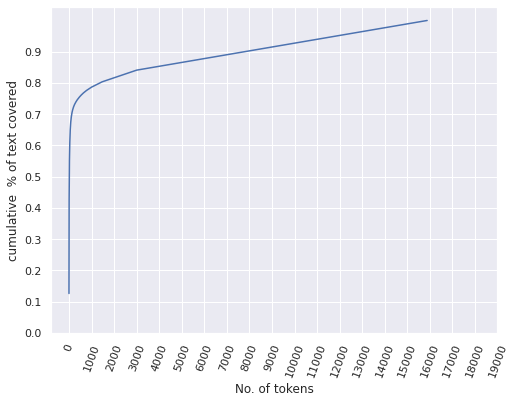

In [34]:
plt.figure(figsize=(8,6))
plt.plot(arr)
plt.yticks(np.arange(0,1,0.1))
plt.xticks(np.arange(0,20000,1000),rotation=70)
plt.xlabel("No. of tokens")
plt.ylabel("cumulative  % of text covered")
plt.show()

In [35]:
arr.shape

(15883,)

In [36]:
number_of_net_to_keep = arr.shape[0] - arr[arr>0.80].shape[0]
netremove = list(non_english_tokens.keys())[number_of_net_to_keep:]

This means keeping only the top (most-frequent) 1363 Non-English tokens, we can cover 80% of the text covered by them. 80% can be treated as a hyperparameter of our algorithm. Now we must extract these tokens which must be excluded, and exclude them from our testing set as well. 

In [37]:
X_train['tokenized'] = X_train['tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in netremove]))
X_val['tokenized'] = X_val['tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in netremove]))
X_test['tokenized'] = X_test['tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in netremove]))

In [38]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(19176, 1) (19176,)
(6393, 1) (6393,)
(6393, 1) (6393,)


In [39]:
train = X_train.copy()
train['Sentiment'] = y_train
validation = X_val.copy()
validation['Sentiment'] = y_val
test = X_test.copy()
test['Sentiment'] = y_test

In [40]:
train.to_csv("twittertrain.csv", index=False)
validation.to_csv("twittervalidation.csv", index=False)
test.to_csv("twittertest.csv", index=False)